<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Ex_Self_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplo de self attention

In [1]:
import torch 
import numpy as np
import seaborn as sns

In [2]:
# 00 -- ENTRADA:
text = 'Quero um cartão'
text_tokens = ['Quero', 'um', 'cartão']

# 01 -- IDs:
text_ids = [27,11,83]
VOCAB = 100 # Quantidade de palavras

# 02 -- DIMENSÃO DOS EMBEDDINGS = 4:
D = 4

# 03 -- COMPRIMENTO DA SEQUÊNCIA:
L = 3

# 04 -- MATRIZ DE EMBEDDINGS LxD:
text_emb = torch.tensor([
                         [0,1,2,0], 
                         [1,0,1,1],
                         [1,0,1,2],
                        ]).long()

# 05 -- PRINT - SANITY CHECK:
for i in zip(text_tokens, text_ids, text_emb):
    print(f'Palavra: {i[0] :<6} -- ID: {i[1]} -- Embedding: {i[2]}')

Palavra: Quero  -- ID: 27 -- Embedding: tensor([0, 1, 2, 0])
Palavra: um     -- ID: 11 -- Embedding: tensor([1, 0, 1, 1])
Palavra: cartão -- ID: 83 -- Embedding: tensor([1, 0, 1, 2])


In [3]:
# 06 -- USAR O nn.EMBEDDING PyTorch para CONSTRUIR AS MATRIZ DE PESOS Q, K, V:

embs  = torch.nn.Embedding(VOCAB, D)

# tensor com zeros_like
embeddings = torch.zeros(len(text_ids) * D).reshape(len(text_ids), D) 

print(f'Shape da matriz de embeddings: {embeddings.shape}\n')

print('Texto\t\t\t     Matriz de embeddings\n')
for i , token in enumerate(text_ids):
    embeddings[i] = embs(torch.tensor(token))
embeddings

Shape da matriz de embeddings: torch.Size([3, 4])

Texto			     Matriz de embeddings



tensor([[-0.4409, -0.7220, -0.8106, -0.3540],
        [-0.4031,  0.1947,  0.3793,  0.6797],
        [ 0.0089,  0.4216, -1.2296, -2.1588]], grad_fn=<AsStridedBackward>)

In [11]:
# 06 -- MATRIZ DE PESOS, Q, K, V --> DxD (INICIADOS ARBITRARIAMENTE):

Qw = torch.tensor([
                   [1,  0, -1,  1], 
                   [0,  1,  0, -2],
                   [3,  1, -2,  0],
                   [0, -2,  1,  3],
                ])

Kw = torch.tensor([
                   [3, -1,  0, -1], 
                   [0,  1, -1,  0],
                   [3,  1,  0, -1],
                   [-1, 0,  1,  3],
                 ])

Vw = torch.tensor([
                   [-2, 0,  3,  0], 
                   [-1, 1, -2, -1],
                   [-2, 1,  2,  3],
                   [3,  2,  1, -2],
                 ])

In [12]:
# 07 -- OBTER Q, K e V:
print(f'Shape da entrada: {text_emb.size()} -- Shape das Matrizes de pesos Qw, Kw e Vw: {Qw.size()}')

Shape da entrada: torch.Size([3, 4]) -- Shape das Matrizes de pesos Qw, Kw e Vw: torch.Size([4, 4])


In [13]:
K =  torch.einsum('ab, bc -> ac', text_emb, Kw) # text_emb @ Kw
V =  torch.einsum('ab, bc -> ac', text_emb, Vw) # text_emb @ Vw
Q =  torch.einsum('ab, bc -> ac', text_emb, Qw) # text_emb @ Qw

In [14]:
K

tensor([[ 6,  3, -1, -2],
        [ 5,  0,  1,  1],
        [ 4,  0,  2,  4]])

In [15]:
V

tensor([[-5,  3,  2,  5],
        [-1,  3,  6,  1],
        [ 2,  5,  7, -1]])

In [16]:
Q

tensor([[ 6,  3, -4, -2],
        [ 4, -1, -2,  4],
        [ 4, -3, -1,  7]])

In [32]:
# 08 -- CALCULAR O SCORE:
QKT = torch.einsum('ab, cb -> ac', Q, K) # Q @ K.T
QKT

# 08.1 -- DIVIDIR POR SQRT(D)
QKT = QKT/torch.sqrt(torch.tensor(D))

In [33]:
# 09 -- SOFTMAX:
S = torch.nn.Softmax(dim=-1)
S(QKT.float())

tensor([[1.0000e+00, 5.0435e-07, 1.6919e-10],
        [1.4301e-03, 4.7358e-02, 9.5121e-01],
        [2.0605e-09, 3.3535e-04, 9.9966e-01]])

In [34]:
# 10 -- SIMPLIFICAR S - POR SIMPLICIDADE DE ENTENDIMENTO:
Softmax  = torch.tensor([
                         [1.00, 0.00,  0.00], 
                         [0.06, 0.04,  0.90],
                         [0.00, 0.00,  1.00],
                 ])

In [35]:
# 11 -- SOFTMAX * V (EXTRATOR DE FEAT):
SV = torch.einsum('ab, bc -> ac', Softmax,V.float())
SV 

tensor([[-5.0000,  3.0000,  2.0000,  5.0000],
        [ 1.4600,  4.8000,  6.6600, -0.5600],
        [ 2.0000,  5.0000,  7.0000, -1.0000]])

In [36]:
# 12 -- MULTIPLICAR PELA MATRIZ DE PROJEÇÃO Wo

# PESOS DA Wo (INICIADOS ARBITRARIAMENTE)
Wo = torch.tensor([
                   [2,  0, -1,  1], 
                   [1, -1, -2,  1],
                   [2,  0,  1,  0],
                   [0, -2,  1, -1],
                 ])
Wo.shape

torch.Size([4, 4])

In [37]:
## 13 -- SV @ Wo = MATRIZ DE ATENÇÃO:

ATT = torch.einsum('ab, bc -> ac', SV, Wo.float())/8 # SV @ Wo
ATT

tensor([[-0.3750, -1.6250,  0.7500, -0.8750],
        [ 2.6300, -0.4600, -0.6200,  0.8525],
        [ 2.8750, -0.3750, -0.7500,  1.0000]])

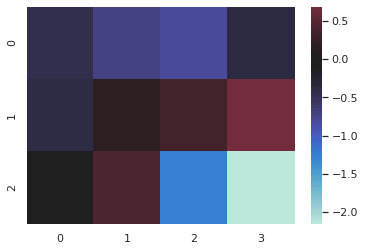

In [38]:
# Embs sem ATT
sns.heatmap(embeddings.detach().numpy(), center=0)

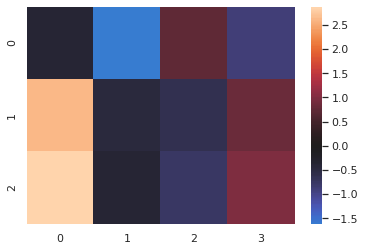

In [39]:
# ATT Embs
sns.heatmap(ATT.detach().numpy(), center=0)

# Fim do Notebook